In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import time

In [2]:
door1 = pd.read_csv("labeled_door1.csv")


In [3]:
door1.head()

,Timestamp,x,y,z,pressure,x_label
0,2975,-9.653112,-9.633959,-9.633959,83.465385,0
1,3015,-9.653112,-9.633959,-9.633959,83.465782,0
2,3055,-9.653112,-9.633959,-9.633959,83.465599,0
3,3095,-9.653112,-9.633959,-9.633959,83.465515,0
4,3134,-9.653112,-9.633959,-9.633959,83.465507,0


In [4]:
def cummulative_sum(i, variableMedian, gMax, gMin, drift):
        s_i = variableMedian[i] - variableMedian[i-1]
        gMax_i = max(gMax[i-1] + s_i - drift, 0)
        gMin_i = max(gMin[i-1] - s_i - drift, 0)
        gMax.append(gMax_i)
        gMin.append(gMax_i)
                
        return gMax_i, gMin_i


def alarmLabeling(drift, threshold, var, var_label, varRange):
    
    x_median = list(var[varRange[0]:varRange[1]])
    x_label = list(var_label[varRange[0]:varRange[1]])
    

    #### CUSUM values #####
    x_alarms = list()           # Points where a movement change is detected
    x_opening = list()          # Points when an upward movement is detected
    x_closing = list()          # Points when an downward movement is detected


    x_gMax = list([0]) # internal variables for CUSUM
    x_gMin = list([0])


    ### STEP Detection ####

    #alarmDetected = False
    alarmInterval = 10             # Alarms closer than this will be considerated consecutive
    x_alarmCounter = 0               # Counter of consecutive alarms
    x_change = list([0])                # Cumulative alarms


    x_closingDetected = False
    x_openingDetected = False
    x_lastAlarm = -1                 # Index of last alarm


    ### Slope ponderation ####

    x_slope = list([0])              # Storing slope
    z_slope = list([0])              
    y_slope = list([0])    


    ### Clean change (remove errors online)

    clean_x_change = list()
    globalMax_x = 0
    globalMin_x = 100000
    lastZero_x = 0   # Last zero before movement

    coef1 = 1.2
    coef2 = 0.5


    ## Detect Open/Closed

    state_x = "unknown"
    stateList_x = list([state_x])



    falseAlarms = list() # alarm detected when movement isnt labeled
    missedAlarms = list() # alarm missed when the movement is labeled
    labeledAlarms = list() # alarm labeled as movement
    correctAlarms = list()
    totalAlarms = 0 # number of  original alarms labelings

    for i in range(0, varRange[1]-varRange[0]):


        ###### CUSUM intervals #####
        # Detect growing and decreasing tendences on the median,
        # Results in a list of indexes of changes
        if(i != 0): 
            x_gMax_i, x_gMin_i = cummulative_sum(i, x_median, x_gMax, x_gMin, drift)

            x_alarmDetected = x_gMax_i > threshold or x_gMin_i > threshold
            if(x_alarmDetected): x_alarms.append(i)

            x_openingDetected = x_gMax_i > threshold
            if(x_openingDetected): x_opening.append(i)

            x_closingDetected = x_gMin_i > threshold
            if(x_closingDetected): x_closing.append(i)   



        #### Step Detection #####
        # Apply ponderation an calculate cumulative movement
        if(i != 0):
            if(x_openingDetected or x_closingDetected):
                x_alarmCounter += 1
                x_lastAlarm = i   
            elif(x_lastAlarm > i - alarmInterval):  # Interval exceded
                x_alarmCounter += 1
            else:
                x_alarmCounter = 0 

            if(x_alarmCounter == 0): x_change.append(0)
            else: x_change.append(1)

        if(x_label[i] == 0 and x_change[i] == 1): falseAlarms.append(i)
        elif(x_label[i] == 1 and x_change[i] == 0): missedAlarms.append(i)
        elif(x_label[i] == 1 and x_change[i] == 1): correctAlarms.append(i)

        if(x_label[i] == 1): totalAlarms += 1


    return falseAlarms, missedAlarms, correctAlarms, totalAlarms

In [8]:
drift = 0.07              # drift: CUSUM parameter
threshold = 0.01          # threshold: CUSUM parameter

# colors: 
# https://matplotlib.org/stable/_images/sphx_glr_named_colors_003_2_0x.png

varRange = [0, 500000]

var = door1.x
var_label = door1.x_label

falseAlarms, missedAlarms, correctAlarms, totalAlarms = alarmLabeling(drift, threshold, var, var_label, varRange)

print("false_alarm: ", len(falseAlarms))
print("missed_alarm: ", len(missedAlarms))
print("correct alarms: ", len(correctAlarms))
print("total: ", totalAlarms)

false_alarm:  217
missed_alarm:  3225
correct alarms:  4946
total:  8171


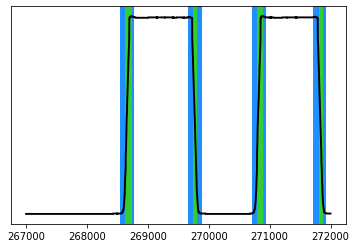

In [21]:
pltRange = [267000, 272000]

for i in correctAlarms:
    if(i > pltRange[0] and i < pltRange[1]):
        plt.axvline(x=i, color='limegreen', linestyle='-')
for i in falseAlarms:
    if(i > pltRange[0] and i < pltRange[1]):
        plt.axvline(x=i, color='red', linestyle='-')

for i in missedAlarms:
    if(i > pltRange[0] and i < pltRange[1]):
        plt.axvline(x=i, color='dodgerblue', linestyle='-')
    
plt.yticks([])

plt.plot(var[pltRange[0]:pltRange[1]], color = "black", linewidth=1.9)

In [ ]:
falseAlarms